In [1]:
import eeg_decoder
import numpy as np
import mord
from collections import OrderedDict
%load_ext autoreload
%autoreload 2

In [26]:
experiment_name = 'C01'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1000])

In [52]:
time_window = 50
time_step = 50
trial_bin_size = 20
n_splits = 4 
group_dict = OrderedDict([('1',[11]),('2',[20])])
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)

In [53]:
from pathlib import Path
import pickle

In [54]:
sub_models = list(Path('models').glob('*'))

In [55]:
acc = np.empty((len(sub_models),exp.nsub,np.size(wrangl.t),wrangl.n_splits))
acc_shuff= np.empty((len(sub_models),exp.nsub,np.size(wrangl.t),wrangl.n_splits))

for imodel,sub_model in enumerate(sub_models):
    print(imodel)
    timepoint_models = list(sub_model.glob('*'))

    for isub in range(exp.nsub):

        xdata,ydata = exp.load_eeg(isub)
        xdata,ydata = wrangl.group_labels(xdata,ydata)
        if xdata.shape[1] > 30:
            print(isub)
            xdata = xdata[:,:30]

        for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

            X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)
            y_test_shuffle = np.random.permutation(y_test)

            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

                clf_f = sub_model / f'{sub_model.parts[1]}_{wrangl.itime}.pkl'

                with open(clf_f, 'rb') as f:
                    clf = pickle.load(f)


                X_train, X_test = clfr.standardize(X_train, X_test)

                acc[imodel,isub, wrangl.itime, wrangl.ifold] = clf.score(X_test, y_test)
                acc_shuff[imodel,isub, wrangl.itime, wrangl.ifold] = clf.score(
                    X_test, y_test_shuffle)

                # clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)


0
19
1
19
2
19
3
19
4
19
5
19
6
19
7
19
8
19
9
19
10
19
11
19
12
19
13
19
14
19
15
19
16
19
17
19
18
19
19
19
20
19
21
19
22
19
23
19
24
19
25
19
26
19
27
19
28
19
29
19
30
19
31
19
32
19


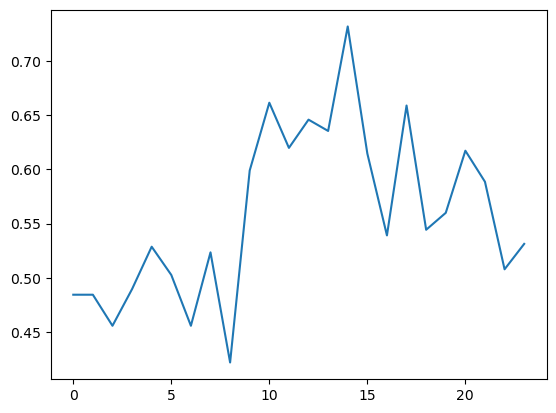

In [108]:
best_train = np.argmax(np.mean(np.mean(np.mean(acc,3),1)[:,wrangl.t>000],1))
worst_train = np.argmin(np.mean(np.mean(np.mean(acc,3),1)[:,wrangl.t>000],1))
plt.plot(np.mean(np.mean(acc,3),1)[best_train]);
plt.show()

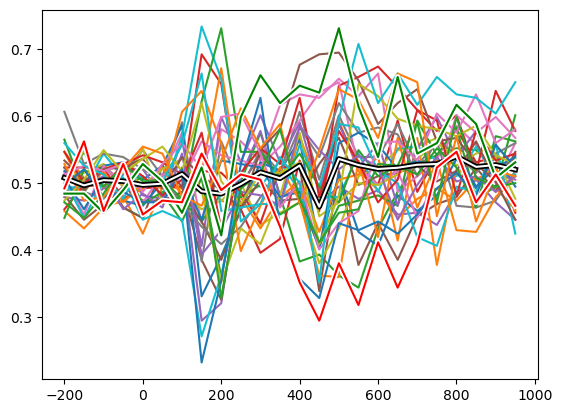

In [111]:
import matplotlib.patheffects as pe
plt.plot(wrangl.t,np.mean(np.mean(acc,3),1).T);
plt.plot(wrangl.t,np.mean(np.mean(np.mean(acc,3),1),0),c='w',path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()],zorder=5);
plt.plot(wrangl.t,np.mean(np.mean(acc,3),1)[best_train],c='g',path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()],zorder=5);
plt.plot(wrangl.t,np.mean(np.mean(acc,3),1)[worst_train],c='r',path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()],zorder=5);
plt.show()


In [144]:
def dice_roll(num_rolls=1):
    rolls = []
    for i in range(num_rolls):
        rolls.append(np.random.randint(6)+1)
    return np.array(rolls)


In [181]:
def dice_reroll(rolls, if_under=4, under_mean=False):
    for i,r in enumerate(rolls):
        if under_mean == True:
            if_under = np.mean(rolls)
        if r < if_under:
            reroll = dice_roll(1)[0]
            rolls[i] = reroll
    return rolls

In [178]:
for if_under in range(6):
    means = []
    for _ in range(10000):
        rolls = dice_roll(5)
        rerolls = dice_reroll(rolls,if_under = if_under+1)
        means.append(np.sum(rerolls))
    print(f'Reroll if under {if_under+1}: {np.mean(means)}')

Reroll if under 1: 17.5389
Reroll if under 2: 19.6061
Reroll if under 3: 20.8606
Reroll if under 4: 21.2804
Reroll if under 5: 20.7876
Reroll if under 6: 19.5456


In [184]:
means = []
for _ in range(10000):
    rolls = dice_roll(5)
    rerolls = dice_reroll(rolls,under_mean = True)
    means.append(np.sum(rerolls))
print(np.mean(means))


20.9487


In [84]:
np.mean(np.mean(acc,3),1).T.shape

(24, 33)

In [128]:
interp = eeg_decoder.Interpreter(clfr, subtitle='1Hv1L') 
interpbad = eeg_decoder.Interpreter(clfr, subtitle='1Hv1L') 
# interp.save_results()

In [121]:
interpbad.acc = interp.acc[[1,3,5,9,10,11,12]]
interp.acc = interp.acc[[0,2,4,6,7,8]]

In [133]:
interp.acc = interp.acc[:,:,:30]
interp.acc_shuff = interp.acc_shuff[:,:,:30]

No handles with labels found to put in legend.


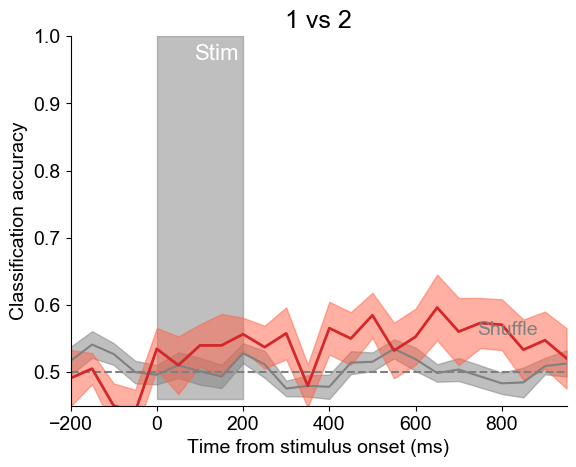

Mean delay accuracy: 0.5506837606837607
Mean delay S.D.: 0.027440556624382485


In [135]:
interp.plot_acc(significance_testing=False,savefig=False,ylim=[.45,1],chance_text_y=.23, title='1 vs 2',stim_time=[0,200])

No handles with labels found to put in legend.


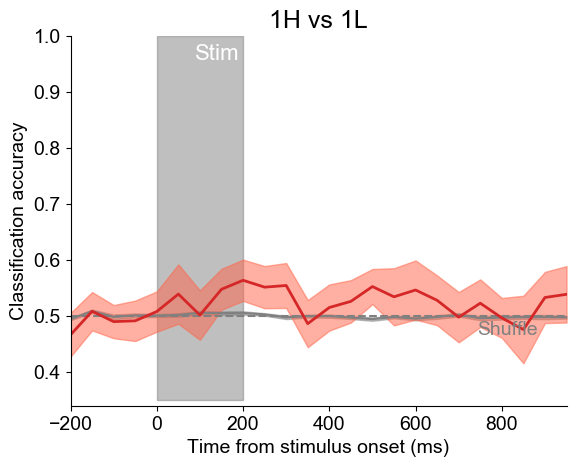

Mean delay accuracy: 0.5242047619047618
Mean delay S.D.: 0.0240572993246052


In [125]:
interpbad.plot_acc(significance_testing=False,savefig=False,ylim=[.34,1],chance_text_y=.23, title='1H vs 1L',stim_time=[0,200])

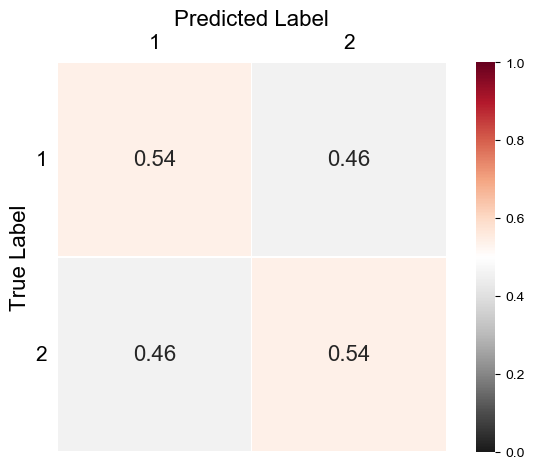

In [126]:
interp.plot_confusion_matrix()

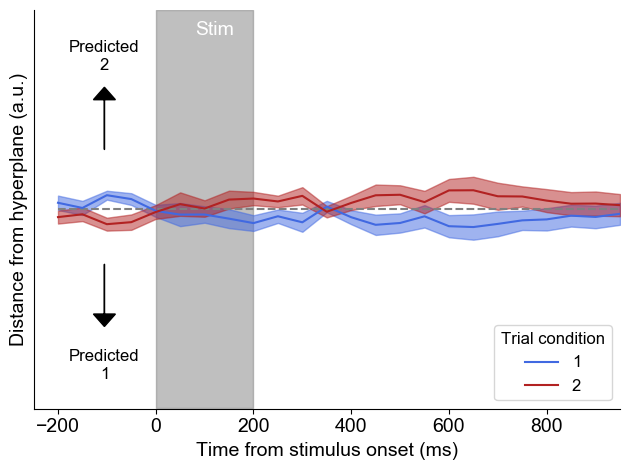

In [127]:
interp.plot_hyperplane(stim_time=[0,200], ylim=[-4,4])